In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) #makes the display bars longer and spread out 100% across the screen width

In [2]:
from vivarium import Artifact
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from db_queries import get_ids, get_outputs
import scipy.stats

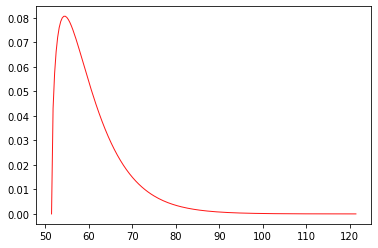

In [3]:
# distribution for the cost of BEP
loc = 51.42
mean = 60.42 - loc
a = 1.5
scale = mean/a
fig, ax = plt.subplots(1,1)
x = np.linspace(loc, loc+(120-50), 200)
ax.plot(x, scipy.stats.gamma.pdf(x, a, loc, scale), 'r-', lw=1, alpha=0.9, label='beta pdf')
plt.show()

In [4]:
%cd '/share/costeffectiveness/results/vivarium_gates_bep/summer_run3/india/2020_09_07_08_30_41'
%ls

/ihme/costeffectiveness/results/vivarium_gates_bep/summer_run3/india/2020_09_07_08_30_41
branches.yaml  keyspace.yaml             output.hdf        settings.py
count_data/    logs/                     __pycache__/
final_data/    model_specification.yaml  requirements.txt


In [5]:
#5_a
run_1_output_dirs = ['/share/costeffectiveness/results/vivarium_gates_bep/fall_2020/5_a/india/2020_10_16_08_59_11/count_data/',
                 '/share/costeffectiveness/results/vivarium_gates_bep/fall_2020/5_a/pakistan/2020_10_16_16_09_17/count_data/',
                 '/share/costeffectiveness/results/vivarium_gates_bep/fall_2020/5_a/mali/2020_10_16_16_06_10/count_data/',
                 '/share/costeffectiveness/results/vivarium_gates_bep/fall_2020/5_a/tanzania/2020_10_16_16_12_19/count_data/']

#5_b
run_2_output_dirs = ['/share/costeffectiveness/results/vivarium_gates_bep/fall_2020/5_b/india/2020_10_14_14_43_07/count_data/',
                 '/share/costeffectiveness/results/vivarium_gates_bep/fall_2020/5_b/pakistan/2020_10_16_16_19_08/count_data/',
                 '/share/costeffectiveness/results/vivarium_gates_bep/fall_2020/5_b/mali/2020_10_16_16_16_56/count_data/',
                 '/share/costeffectiveness/results/vivarium_gates_bep/fall_2020/5_b/tanzania/2020_10_16_16_22_21/count_data/']

#location labels
locations = ['India','Pakistan','Mali','Tanzania']

#use in sort_values to make custum sort list. I sorted by region. 
sorter = ['India','Pakistan','Mali','Tanzania']
sorterIndex = dict(zip(sorter,range(len(sorter))))

!whoami
!date


nicoly
Sun Oct 25 23:25:07 PDT 2020


In [6]:
def read_count_data(data_file):
    data = pd.DataFrame()
    for i in list(range(0,len(run_1_output_dirs))):
        temp1 = pd.read_hdf(run_1_output_dirs[i] + data_file + '.hdf')
        temp2 = pd.read_hdf(run_2_output_dirs[i] + data_file + '.hdf')
        temp = temp1.append(temp2)
        temp['location'] = locations[i]
        temp['location_rank'] = temp['location'].map(sorterIndex)
        temp = temp.sort_values(by='location_rank')
        temp = temp.drop(columns=['location_rank'])
        data = data.append(temp)
    return data


# READ COUNT DATA FROM HDF

In [7]:
ylls = read_count_data('ylls')
ylds = read_count_data('ylds')
person_time = read_count_data('person_time')
population = read_count_data('population')
deaths = read_count_data('deaths')

# 1. DALYS

total dalys table: overall_result_counts

In [8]:
result_counts = deaths.append(ylls).append(ylds)

# sum across age groups, mother status, cause, treatment group
overall_result_counts = result_counts.groupby(['input_draw','location','scenario','measure']).sum().reset_index()

# calculate dalys
dalys = overall_result_counts.reset_index().loc[overall_result_counts.reset_index().measure.isin(['ylds','ylls'])]

dalys = dalys.groupby(['input_draw','location','scenario']).sum().reset_index().drop(columns='index')
dalys['measure'] = 'dalys'

overall_result_counts = overall_result_counts.append(dalys).set_index(['input_draw','location','measure','scenario']).sort_index()

overall_result_counts.head()

/share/code/nicoly/miniconda/envs/gates_bep/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


value
input_draw location measure scenario                               
3          India    dalys   baseline                  322427.572855
                            bep_ce_scale_up           305820.181320
                            bep_ce_targeted_scale_up  306962.334525
                            bep_hd_scale_up           285936.847711
                            bep_hd_targeted_scale_up  305091.433373

### testing ylls + ylds = dalys

In [9]:
# test that dalys = ylls + ylds

test = overall_result_counts.reset_index()
test_ylls = test.loc[test.measure == 'ylls'].set_index(['input_draw','location','scenario']).drop(columns='measure')
test_deaths = test.loc[test.measure == 'death'].set_index(['input_draw','location','scenario']).drop(columns='measure')
test_ylds = test.loc[test.measure == 'ylds'].set_index(['input_draw','location','scenario']).drop(columns='measure')
test_dalys = test.loc[test.measure == 'dalys'].set_index(['input_draw','location','scenario']).drop(columns='measure')

assert np.all(test_ylls > test_ylds)
assert np.all(test_dalys == test_ylls + test_ylds)
assert np.all(test_ylls > test_deaths)

In [10]:
# sum across age groups, mother status, cause, treatment group

overall_births = population.loc[population.treatment_group == 'all']
overall_births = overall_births.loc[overall_births.measure == 'total_population']
overall_births = overall_births.groupby(['input_draw','location','scenario']).sum()

assert len(overall_births.value.unique()) == 1, "WARNING: number of births not the same in each scenario"
assert overall_births.value.unique()[0] == 100_000, "WARNING: number of births not equal to expected value of 100,000"

overall_births.head()

value
input_draw location scenario                          
3          India    baseline                  100000.0
                    bep_ce_scale_up           100000.0
                    bep_ce_targeted_scale_up  100000.0
                    bep_hd_scale_up           100000.0
                    bep_hd_targeted_scale_up  100000.0

# 2. AVERTED DALYS

### relative to baseline

averted dalys relative to baseline table: averted_counts

In [11]:
# averted counts relative to baseline
baseline_counts = (overall_result_counts.reset_index()
                   .loc[overall_result_counts.reset_index().scenario == 'baseline']
                   .drop(columns='scenario')
                   .set_index(['input_draw','location','measure']))

averted_counts = baseline_counts - overall_result_counts.reset_index().set_index(['input_draw','location','measure','scenario'])
averted_counts.head()

value
input_draw location measure scenario                              
3          India    dalys   baseline                      0.000000
                            bep_ce_scale_up           16607.391535
                            bep_ce_targeted_scale_up  15465.238330
                            bep_hd_scale_up           36490.725144
                            bep_hd_targeted_scale_up  17336.139482

### relative to MMN

averted_rel_mmn_counts

In [12]:
#for mmn_scale_up scenario only

mmn_counts = (overall_result_counts.reset_index()
                   .loc[overall_result_counts.reset_index().scenario == 'mmn_scale_up']
                   .drop(columns='scenario')
                   .set_index(['input_draw','location','measure']))
mmn_counts.head()

value
input_draw location measure               
3          India    dalys    309861.364232
                    death      3523.000000
                    ylds        956.462987
                    ylls     308904.901245
           Mali     dalys    716206.185301

In [13]:
# averted counts relative to mmn
mmn_counts = (overall_result_counts.reset_index()
                   .loc[overall_result_counts.reset_index().scenario == 'mmn_scale_up']
                   .drop(columns='scenario')
                   .set_index(['input_draw','location','measure']))

averted_rel_mmn_counts = mmn_counts - overall_result_counts.reset_index().set_index(['input_draw','location','measure','scenario'])

averted_rel_mmn_counts=averted_rel_mmn_counts.reset_index()
averted_rel_mmn_counts=averted_rel_mmn_counts[averted_rel_mmn_counts['scenario'] != 'baseline'].set_index(['input_draw','location','measure','scenario'])

#averted_rel_mmn_counts = averted_rel_mmn_counts.query('scenario' != 'baseline')
#NEED TO FIGURE OUT A BETTER WAY TO DROP BASELINE ROW

averted_rel_mmn_counts.head(10)


value
input_draw location measure scenario                              
3          India    dalys   bep_ce_scale_up            4041.182912
                            bep_ce_targeted_scale_up   2899.029707
                            bep_hd_scale_up           23924.516520
                            bep_hd_targeted_scale_up   4769.930858
                            mmn_scale_up                  0.000000
                    death   bep_ce_scale_up              46.000000
                            bep_ce_targeted_scale_up     33.000000
                            bep_hd_scale_up             271.000000
                            bep_hd_targeted_scale_up     54.000000
                            mmn_scale_up                  0.000000

# 3. Number treated/supplemented counts 

treatment_counts

In [14]:
treatment_counts = population.loc[population.treatment_group != 'all']
treatment_counts = treatment_counts.groupby(['input_draw','location','scenario','treatment_group']).sum()

assert treatment_counts.groupby(['input_draw','location','scenario']).sum().value.unique()[0] == 100_000, "ERROR: sum of treatment counts across input draws and scenario does not equal expected value of 100,000 for all scenarios/draws"

treatment_counts.head()

value
input_draw location scenario        treatment_group         
3          India    baseline        bep                  0.0
                                    ifa              35192.0
                                    mmn                  0.0
                                    none             64808.0
                    bep_ce_scale_up bep              79789.0

# 4. Treatment cost per scenario

cost

In [15]:
# make cost per treatment dataframe

input_draws = treatment_counts.reset_index()['input_draw'].unique()

ifa_cost = pd.DataFrame()
ifa_cost['input_draw'] = input_draws
ifa_cost['value'] = 2.69
ifa_cost['treatment_group'] = 'ifa'

mmn_cost = pd.DataFrame()
mmn_cost['input_draw'] = input_draws
mmn_cost['value'] = 3.69
mmn_cost['treatment_group'] = 'mmn'

np.random.seed(12345)
bep_cost = pd.DataFrame()
bep_cost['input_draw'] = input_draws
bep_cost['value'] = scipy.stats.gamma.rvs(a, loc, scale, size=len(bep_cost)) + 3.69
bep_cost['treatment_group'] = 'bep'

none_cost = pd.DataFrame()
none_cost['input_draw'] = input_draws
none_cost['value'] = 0
none_cost['treatment_group'] = 'none'

costs = ifa_cost.append(mmn_cost).append(bep_cost).append(none_cost).set_index(['input_draw','treatment_group'])
costs.head()

,,value
input_draw,treatment_group,
3,ifa,2.69
21,ifa,2.69
29,ifa,2.69
55,ifa,2.69
78,ifa,2.69


## overall costs per scenario

overall_costs

In [16]:
treatment_counts.reset_index().set_index(['input_draw','treatment_group','location','scenario']).head()

value
input_draw treatment_group location scenario                
3          bep             India    baseline             0.0
           ifa             India    baseline         35192.0
           mmn             India    baseline             0.0
           none            India    baseline         64808.0
           bep             India    bep_ce_scale_up  79789.0

In [17]:
overall_costs = treatment_counts.reset_index().set_index(['input_draw','treatment_group','location','scenario']) * costs
overall_costs = overall_costs.reset_index().groupby(['input_draw','location','scenario']).sum()
overall_costs.head()

value
input_draw location scenario                              
3          India    baseline                  9.466648e+04
                    bep_ce_scale_up           4.856388e+06
                    bep_ce_targeted_scale_up  1.065432e+06
                    bep_hd_scale_up           4.856388e+06
                    bep_hd_targeted_scale_up  1.065432e+06

In [18]:
# check ordering of costs for scenarios
test = overall_costs.reset_index()
test_baseline = test.loc[test.scenario == 'baseline'].drop(columns='scenario').set_index(['input_draw','location'])
test_mmn = test.loc[test.scenario == 'mmn_scale_up'].drop(columns='scenario').set_index(['input_draw','location'])
test_bep_ce_scale_up = test.loc[test.scenario == 'bep_ce_scale_up'].drop(columns='scenario').set_index(['input_draw','location'])
test_bep_ce_targeted_scale_up = test.loc[test.scenario == 'bep_ce_targeted_scale_up'].drop(columns='scenario').set_index(['input_draw','location'])
test_bep_hd_scale_up = test.loc[test.scenario == 'bep_hd_scale_up'].drop(columns='scenario').set_index(['input_draw','location'])
test_bep_hd_targeted_scale_up = test.loc[test.scenario == 'bep_hd_targeted_scale_up'].drop(columns='scenario').set_index(['input_draw','location'])

assert np.all(test_baseline < test_mmn)
assert np.all(test_mmn < test_bep_ce_targeted_scale_up)
assert np.all(test_bep_ce_targeted_scale_up < test_bep_ce_scale_up)
assert np.all(test_bep_ce_targeted_scale_up == test_bep_hd_targeted_scale_up)
assert np.all(test_bep_ce_scale_up == test_bep_hd_scale_up)

# 5. COST DIFFERENCE

In [19]:
baseline_costs = (overall_costs.reset_index()
                  .loc[overall_costs.reset_index().scenario == 'baseline']
                  .drop(columns='scenario')
                  .set_index(['input_draw','location']))
incremental_costs = overall_costs - baseline_costs
incremental_costs.head()

value
input_draw location scenario                              
3          India    baseline                  0.000000e+00
                    bep_ce_scale_up           4.761722e+06
                    bep_ce_targeted_scale_up  9.707650e+05
                    bep_hd_scale_up           4.761722e+06
                    bep_hd_targeted_scale_up  9.707650e+05

# 6. ICERS !!!!!!!!

icers_summarized

In [20]:
icers = incremental_costs / averted_counts.reset_index().set_index(['input_draw','location','scenario','measure'])
icers_summarized = icers.groupby(['location','scenario','measure']).describe(percentiles=[0.025,0.975])
icers_summarized = icers_summarized.reset_index().loc[icers_summarized.reset_index().scenario != 'baseline'].loc[icers_summarized.reset_index().measure == 'dalys']
icers_summarized.head()

location                  scenario measure value                         \
                                              count        mean        std   
4     India           bep_ce_scale_up   dalys  50.0  292.206456  84.080823   
8     India  bep_ce_targeted_scale_up   dalys  50.0   64.302707  13.155231   
12    India           bep_hd_scale_up   dalys  50.0  136.753816  22.944623   
16    India  bep_hd_targeted_scale_up   dalys  50.0   54.121340   9.520813   
20    India              mmn_scale_up   dalys  50.0   15.482052   3.693142   

                                                                
           min        2.5%         50%       97.5%         max  
4   183.928191  188.903361  277.597861  496.555473  576.282913  
8    44.654953   45.977147   64.167505  103.510673  109.896282  
12   98.887307  105.643089  133.827577  174.799927  233.936698  
16   39.682012   40.553710   53.898368   78.921043   89.596186  
20   10.003340   10.346325   15.249858   21.461945   30.828814

# PLOT 1

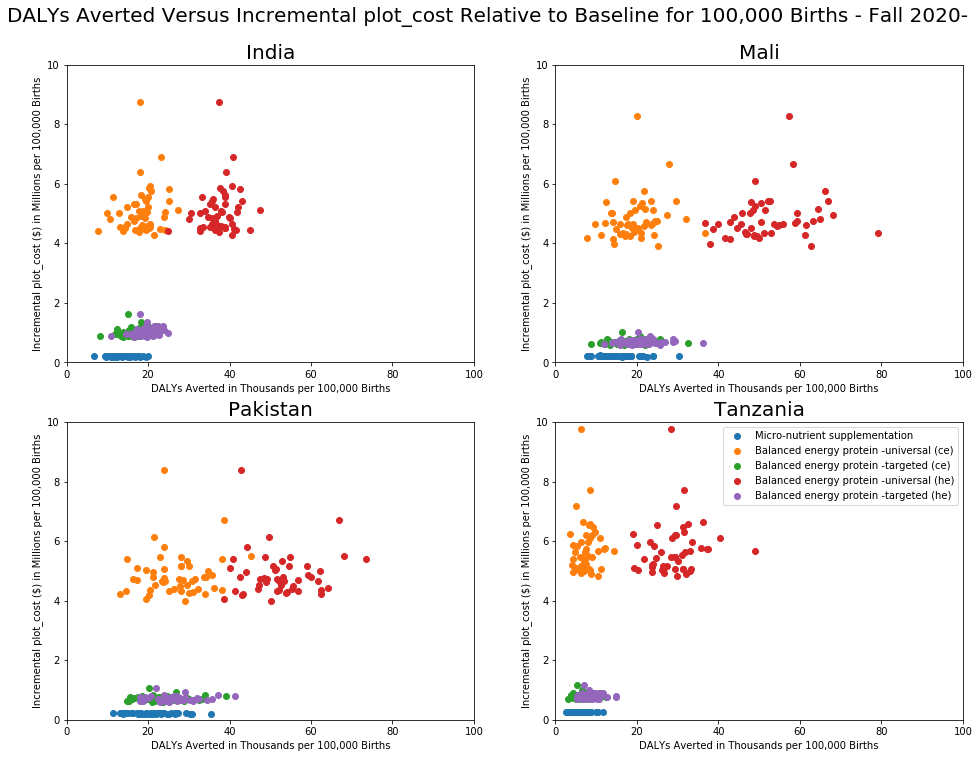

In [21]:
fig, axs = plt.subplots(2,2)

plot_dalys = averted_counts.reset_index()
plot_dalys = plot_dalys.loc[plot_dalys.scenario != 'baseline'].loc[plot_dalys.measure == 'dalys']
plot_dalys['value'] = plot_dalys['value'] / 1_000

plot_cost = incremental_costs.reset_index()
plot_cost = plot_cost.loc[plot_cost.scenario != 'baseline']
plot_cost['value'] = plot_cost['value'] / 1_000_000

ylim = 10
xlim = 100

scenarios = ['mmn_scale_up',
             'bep_ce_scale_up', 
             'bep_ce_targeted_scale_up',
             'bep_hd_scale_up',
             'bep_hd_targeted_scale_up']

scenarios_names = ['Micro-nutrient supplementation',
                   'Balanced energy protein -universal (ce)', 
                   'Balanced energy protein -targeted (ce)',
                   'Balanced energy protein -universal (he)',
                   'Balanced energy protein -targeted (he)']

location = 'India'
for scenario in scenarios:
    axs[0,0].scatter(plot_dalys.loc[plot_dalys.location == location].loc[plot_dalys.scenario == scenario]['value'].values,
                 plot_cost.loc[plot_cost.location == location].loc[plot_cost.scenario == scenario]['value'].values)
axs[0,0].set_title(location,fontsize=20)
axs[0,0].set_ylim(0,ylim)
axs[0,0].set_xlim(0,xlim)
    
location = 'Mali'
for scenario in scenarios:
    axs[0,1].scatter(plot_dalys.loc[plot_dalys.location == location].loc[plot_dalys.scenario == scenario]['value'].values,
                 plot_cost.loc[plot_cost.location == location].loc[plot_cost.scenario == scenario]['value'].values)
axs[0,1].set_title(location,fontsize=20)
axs[0,1].set_ylim(0,ylim)
axs[0,1].set_xlim(0,xlim)
    
location = 'Pakistan'
for scenario in scenarios:
    axs[1,0].scatter(plot_dalys.loc[plot_dalys.location == location].loc[plot_dalys.scenario == scenario]['value'].values,
                 plot_cost.loc[plot_cost.location == location].loc[plot_cost.scenario == scenario]['value'].values)
axs[1,0].set_title(location,fontsize=20)
axs[1,0].set_ylim(0,ylim)
axs[1,0].set_xlim(0,xlim)
    
location = 'Tanzania'
for scenario in scenarios:
    axs[1,1].scatter(plot_dalys.loc[plot_dalys.location == location].loc[plot_dalys.scenario == scenario]['value'].values,
                 plot_cost.loc[plot_cost.location == location].loc[plot_cost.scenario == scenario]['value'].values)
axs[1,1].set_title(location,fontsize=20)
axs[1,1].set_ylim(0,ylim)
axs[1,1].set_xlim(0,xlim)

for ax in axs.flat:
    ax.set(xlabel='DALYs Averted in Thousands per 100,000 Births', 
           ylabel='Incremental plot_cost ($) in Millions per 100,000 Births')
    
plt.legend(scenarios_names)
plt.suptitle('DALYs Averted Versus Incremental plot_cost Relative to Baseline for 100,000 Births - Fall 2020-',x=1.1,y=2.6,fontsize=20)
plt.subplots_adjust(right=2.2, top=2.4)

# PLOT 2

Text(0.5, 1.0, 'DALYs in Thousands per 100,000 Births - FALL 2020 -')

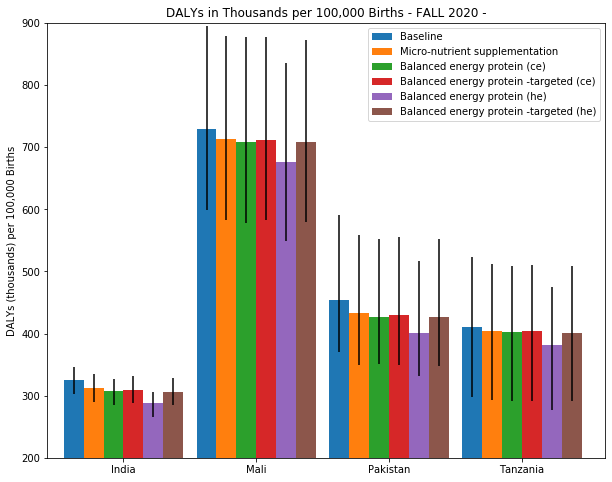

In [22]:
data = overall_result_counts.reset_index()
data = data.loc[data.measure == 'dalys']
data = data.groupby(['location','scenario']).describe(percentiles=[0.025,0.975]).reset_index()
data['value'] = data['value'] / 1_000

# bar width
barWidth = 0.15
w = 0.15

scenarios = ['baseline',
             'mmn_scale_up',
             'bep_ce_scale_up', 
             'bep_ce_targeted_scale_up',
             'bep_hd_scale_up',
             'bep_hd_targeted_scale_up']

scenarios_names = ['Baseline',
                   'Micro-nutrient supplementation',
                   'Balanced energy protein (ce)', 
                   'Balanced energy protein -targeted (ce)',
                   'Balanced energy protein (he)',
                   'Balanced energy protein -targeted (he)']
             

mean_1 = data.loc[data.scenario == scenarios[0]]['value','mean'].values
upper_1 = data.loc[data.scenario == scenarios[0]]['value','max'].values - data.loc[data.scenario == scenarios[0]]['value','mean'].values 
lower_1 = data.loc[data.scenario == scenarios[0]]['value','mean'].values - data.loc[data.scenario == scenarios[0]]['value','min'].values 

mean_2 = data.loc[data.scenario == scenarios[1]]['value','mean'].values
upper_2 = data.loc[data.scenario == scenarios[1]]['value','max'].values - data.loc[data.scenario == scenarios[1]]['value','mean'].values 
lower_2 = data.loc[data.scenario == scenarios[1]]['value','mean'].values - data.loc[data.scenario == scenarios[1]]['value','min'].values 

mean_3 = data.loc[data.scenario == scenarios[2]]['value','mean'].values
upper_3 = data.loc[data.scenario == scenarios[2]]['value','max'].values - data.loc[data.scenario == scenarios[2]]['value','mean'].values 
lower_3 = data.loc[data.scenario == scenarios[2]]['value','mean'].values - data.loc[data.scenario == scenarios[2]]['value','min'].values 

mean_4 = data.loc[data.scenario == scenarios[3]]['value','mean'].values
upper_4 = data.loc[data.scenario == scenarios[3]]['value','max'].values - data.loc[data.scenario == scenarios[3]]['value','mean'].values 
lower_4 = data.loc[data.scenario == scenarios[3]]['value','mean'].values - data.loc[data.scenario == scenarios[3]]['value','min'].values 

mean_5 = data.loc[data.scenario == scenarios[4]]['value','mean'].values
upper_5 = data.loc[data.scenario == scenarios[4]]['value','max'].values - data.loc[data.scenario == scenarios[4]]['value','mean'].values 
lower_5 = data.loc[data.scenario == scenarios[4]]['value','mean'].values - data.loc[data.scenario == scenarios[4]]['value','min'].values 

mean_6 = data.loc[data.scenario == scenarios[5]]['value','mean'].values
upper_6 = data.loc[data.scenario == scenarios[5]]['value','max'].values - data.loc[data.scenario == scenarios[5]]['value','mean'].values 
lower_6 = data.loc[data.scenario == scenarios[5]]['value','mean'].values - data.loc[data.scenario == scenarios[5]]['value','min'].values 

# plot
plt.figure(figsize=(10,8))

a = np.arange(len(mean_1))
b = [x + barWidth for x in a]
c = [x + barWidth for x in b]
d = [x + barWidth for x in c]
e = [x + barWidth for x in d]
f = [x + barWidth for x in e]

plt.bar(a, mean_1, yerr=[lower_1, upper_1], width=barWidth)
plt.bar(b, mean_2, yerr=[lower_2, upper_2], width=barWidth)
plt.bar(c, mean_3, yerr=[lower_3, upper_3], width=barWidth)
plt.bar(d, mean_4, yerr=[lower_4, upper_4], width=barWidth)
plt.bar(e, mean_5, yerr=[lower_5, upper_5], width=barWidth)
plt.bar(f, mean_6, yerr=[lower_6, upper_6], width=barWidth)

plt.yticks([200,300,400,500,600,700,800,900,1000],[200,300,400,500,600,700,800,900,1000])
plt.legend(scenarios_names)
plt.xticks([r + 2.5*barWidth for r in range(len(mean_1))], data.location.unique())

plt.axis([-0.2 , 4 , 200, 900])
plt.ylabel('DALYs (thousands) per 100,000 Births')
plt.title('DALYs in Thousands per 100,000 Births - FALL 2020 -')
#scenarios[1]

# PLOT 3

In [23]:
averted_counts.head()

value
input_draw location measure scenario                              
3          India    dalys   baseline                      0.000000
                            bep_ce_scale_up           16607.391535
                            bep_ce_targeted_scale_up  15465.238330
                            bep_hd_scale_up           36490.725144
                            bep_hd_targeted_scale_up  17336.139482

In [24]:
data = averted_counts.reset_index()
data = data.loc[data.measure == 'dalys']
data = data.groupby(['location','scenario']).describe(percentiles=[0.025,0.975]).reset_index()

mean_1 = data.loc[data.scenario == scenarios[0]]['value','mean'].values
mean_1

array([0., 0., 0., 0.])

Text(0.5, 1.0, 'DALYs averted in Thousands per 100,000 Births - FALL 2020 -')

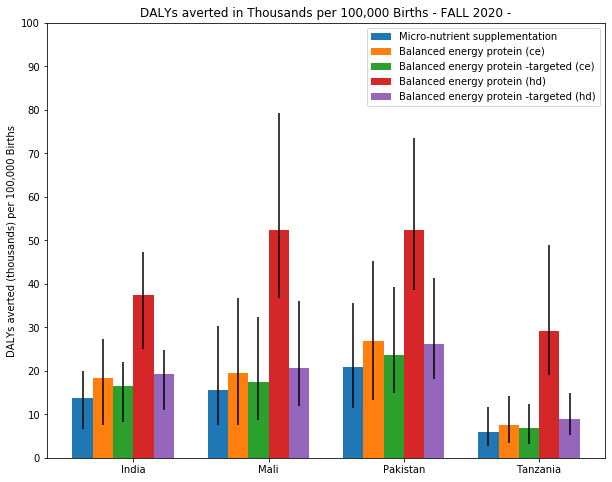

In [25]:
data = averted_counts.reset_index()
data = data.loc[data.measure == 'dalys']
data = data.groupby(['location','scenario']).describe(percentiles=[0.025,0.975]).reset_index()
data['value'] = data['value'] / 1_000

# bar width
barWidth = 0.15
w = 0.15

scenarios = ['mmn_scale_up',
             'bep_ce_scale_up', 
             'bep_ce_targeted_scale_up',
             'bep_hd_scale_up',
             'bep_hd_targeted_scale_up']

scenarios_names = ['Micro-nutrient supplementation',
                   'Balanced energy protein (ce)', 
                   'Balanced energy protein -targeted (ce)',
                   'Balanced energy protein (hd)',
                   'Balanced energy protein -targeted (hd)']
             
             
mean_1 = data.loc[data.scenario == scenarios[0]]['value','mean'].values
upper_1 = data.loc[data.scenario == scenarios[0]]['value','max'].values - data.loc[data.scenario == scenarios[0]]['value','mean'].values 
lower_1 = data.loc[data.scenario == scenarios[0]]['value','mean'].values - data.loc[data.scenario == scenarios[0]]['value','min'].values 

mean_2 = data.loc[data.scenario == scenarios[1]]['value','mean'].values
upper_2 = data.loc[data.scenario == scenarios[1]]['value','max'].values - data.loc[data.scenario == scenarios[1]]['value','mean'].values 
lower_2 = data.loc[data.scenario == scenarios[1]]['value','mean'].values - data.loc[data.scenario == scenarios[1]]['value','min'].values 

mean_3 = data.loc[data.scenario == scenarios[2]]['value','mean'].values
upper_3 = data.loc[data.scenario == scenarios[2]]['value','max'].values - data.loc[data.scenario == scenarios[2]]['value','mean'].values 
lower_3 = data.loc[data.scenario == scenarios[2]]['value','mean'].values - data.loc[data.scenario == scenarios[2]]['value','min'].values 

mean_4 = data.loc[data.scenario == scenarios[3]]['value','mean'].values
upper_4 = data.loc[data.scenario == scenarios[3]]['value','max'].values - data.loc[data.scenario == scenarios[3]]['value','mean'].values 
lower_4 = data.loc[data.scenario == scenarios[3]]['value','mean'].values - data.loc[data.scenario == scenarios[3]]['value','min'].values 

mean_5 = data.loc[data.scenario == scenarios[4]]['value','mean'].values
upper_5 = data.loc[data.scenario == scenarios[4]]['value','max'].values - data.loc[data.scenario == scenarios[4]]['value','mean'].values 
lower_5 = data.loc[data.scenario == scenarios[4]]['value','mean'].values - data.loc[data.scenario == scenarios[4]]['value','min'].values 

# plot
plt.figure(figsize=(10,8))

a = np.arange(len(mean_1))
b = [x + barWidth for x in a]
c = [x + barWidth for x in b]
d = [x + barWidth for x in c]
e = [x + barWidth for x in d]
f = [x + barWidth for x in e]

plt.bar(a, mean_1, yerr=[lower_1, upper_1], width=barWidth)
plt.bar(b, mean_2, yerr=[lower_2, upper_2], width=barWidth)
plt.bar(c, mean_3, yerr=[lower_3, upper_3], width=barWidth)
plt.bar(d, mean_4, yerr=[lower_4, upper_4], width=barWidth)
plt.bar(e, mean_5, yerr=[lower_5, upper_5], width=barWidth)


plt.yticks([0,10,20,30,40,50,60,70,80,90,100])
plt.legend(scenarios_names)
plt.xticks([r + 2.5*barWidth for r in range(len(mean_1))], data.location.unique())

#plt.axis([-0.2 , 4 , 200, 900])
plt.ylabel('DALYs averted (thousands) per 100,000 Births')
plt.title('DALYs averted in Thousands per 100,000 Births - FALL 2020 -')
#scenarios[1]

In [26]:
# LOOKS LIKE THE ERROR BARS WERE UPSIDE DOWN IN NICOLE'S NOTEBOOK
data.loc[data.location=='Mali'].loc[data.scenario=='baseline']['value']

# see that the max value for mali baseline is almost 900, not the case for nicole's plot

### WE CORRECTED FOR THIS!!! :) :) :) :)

,count,mean,std,min,2.5%,50%,97.5%,max
6,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# PLOT 4

Text(0.5, 1.0, 'Incrememntal Cost Effectiveness Ratio (ICER) - FALL 2020 -')

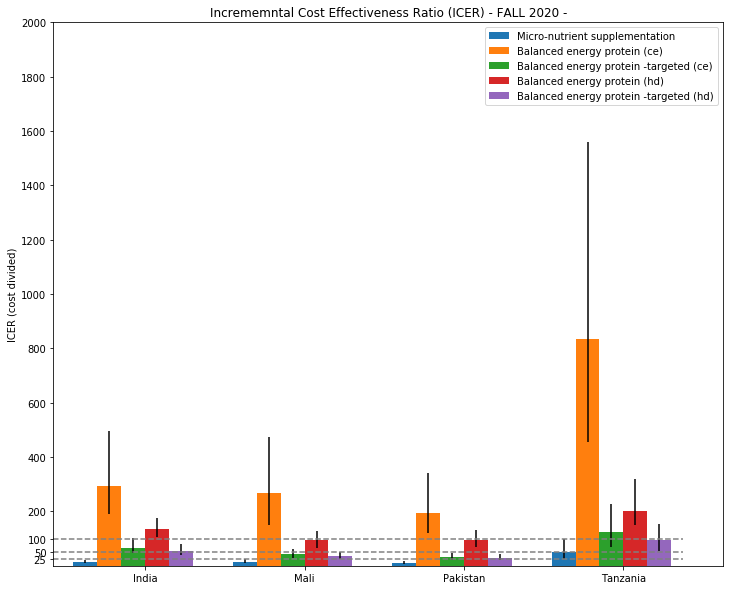

In [27]:
data = icers_summarized.reset_index()

# bar width
barWidth = 0.15
w = 0.15

scenarios = ['mmn_scale_up',
             'bep_ce_scale_up', 
             'bep_ce_targeted_scale_up',
             'bep_hd_scale_up',
             'bep_hd_targeted_scale_up']

scenarios_names = ['Micro-nutrient supplementation',
                   'Balanced energy protein (ce)', 
                   'Balanced energy protein -targeted (ce)',
                   'Balanced energy protein (hd)',
                   'Balanced energy protein -targeted (hd)']
             

mean_1 = data.loc[data.scenario == scenarios[0]]['value','mean'].values
upper_1 = data.loc[data.scenario == scenarios[0]]['value','97.5%'].values - data.loc[data.scenario == scenarios[0]]['value','mean'].values 
lower_1 = data.loc[data.scenario == scenarios[0]]['value','mean'].values - data.loc[data.scenario == scenarios[0]]['value','2.5%'].values 

mean_2 = data.loc[data.scenario == scenarios[1]]['value','mean'].values
upper_2 = data.loc[data.scenario == scenarios[1]]['value','97.5%'].values - data.loc[data.scenario == scenarios[1]]['value','mean'].values 
lower_2 = data.loc[data.scenario == scenarios[1]]['value','mean'].values - data.loc[data.scenario == scenarios[1]]['value','2.5%'].values 

mean_3 = data.loc[data.scenario == scenarios[2]]['value','mean'].values
upper_3 = data.loc[data.scenario == scenarios[2]]['value','97.5%'].values - data.loc[data.scenario == scenarios[2]]['value','mean'].values 
lower_3 = data.loc[data.scenario == scenarios[2]]['value','mean'].values - data.loc[data.scenario == scenarios[2]]['value','2.5%'].values 

mean_4 = data.loc[data.scenario == scenarios[3]]['value','mean'].values
upper_4 = data.loc[data.scenario == scenarios[3]]['value','97.5%'].values - data.loc[data.scenario == scenarios[3]]['value','mean'].values 
lower_4 = data.loc[data.scenario == scenarios[3]]['value','mean'].values - data.loc[data.scenario == scenarios[3]]['value','2.5%'].values 

mean_5 = data.loc[data.scenario == scenarios[4]]['value','mean'].values
upper_5 = data.loc[data.scenario == scenarios[4]]['value','97.5%'].values - data.loc[data.scenario == scenarios[4]]['value','mean'].values 
lower_5 = data.loc[data.scenario == scenarios[4]]['value','mean'].values - data.loc[data.scenario == scenarios[4]]['value','2.5%'].values 

a = np.arange(len(mean_1))
b = [x + barWidth for x in a]
c = [x + barWidth for x in b]
d = [x + barWidth for x in c]
e = [x + barWidth for x in d]
f = [x + barWidth for x in e]

plt.figure(figsize=(12,10))

plt.bar(a, mean_1, yerr=[lower_1, upper_1], width=barWidth)
plt.bar(b, mean_2, yerr=[lower_2, upper_2], width=barWidth)
plt.bar(c, mean_3, yerr=[lower_3, upper_3], width=barWidth)
plt.bar(d, mean_4, yerr=[lower_4, upper_4], width=barWidth)
plt.bar(e, mean_5, yerr=[lower_5, upper_5], width=barWidth)

plt.legend(scenarios_names)

threshold = 100
threshold2 = 50
threshold3 = 25
plt.plot([-0.25,len(a)-.25], [threshold, threshold],'k--', c='gray')
plt.plot([-0.25,len(a)-.25], [threshold2, threshold2],'k--', c='gray')
plt.plot([-0.25,len(a)-.25], [threshold3, threshold3],'k--', c='gray')

plt.xticks([r + 2.5*barWidth for r in range(len(mean_1))], data.location.unique())
plt.axis([-0.2 , 4 , 0, 1000])
plt.yticks([25,50,100,200,400,600,800,1000,1200,1400,1600,1800,2000])
#plt.yscale('log')
plt.ylabel('ICER (cost divided)')
plt.title('Incrememntal Cost Effectiveness Ratio (ICER) - FALL 2020 -')

/share/code/nicoly/miniconda/envs/gates_bep/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


Text(0.5, 1.0, 'Incremental Cost Effectiveness Ratio (ICER) logscale - FALL 2020 -')

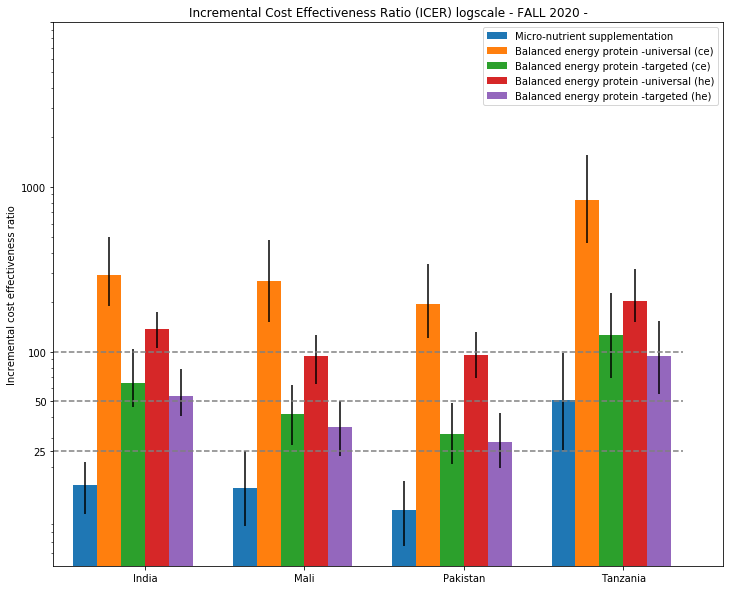

In [28]:
#LOG SCALE

data = icers_summarized.reset_index()

# bar width
barWidth = 0.15
w = 0.15

scenarios = ['mmn_scale_up',
             'bep_ce_scale_up', 
             'bep_ce_targeted_scale_up',
             'bep_hd_scale_up',
             'bep_hd_targeted_scale_up']

scenarios_names = ['Micro-nutrient supplementation',
                   'Balanced energy protein -universal (ce)', 
                   'Balanced energy protein -targeted (ce)',
                   'Balanced energy protein -universal (he)',
                   'Balanced energy protein -targeted (he)']
             

mean_1 = data.loc[data.scenario == scenarios[0]]['value','mean'].values
upper_1 = data.loc[data.scenario == scenarios[0]]['value','97.5%'].values - data.loc[data.scenario == scenarios[0]]['value','mean'].values 
lower_1 = data.loc[data.scenario == scenarios[0]]['value','mean'].values - data.loc[data.scenario == scenarios[0]]['value','2.5%'].values 

mean_2 = data.loc[data.scenario == scenarios[1]]['value','mean'].values
upper_2 = data.loc[data.scenario == scenarios[1]]['value','97.5%'].values - data.loc[data.scenario == scenarios[1]]['value','mean'].values 
lower_2 = data.loc[data.scenario == scenarios[1]]['value','mean'].values - data.loc[data.scenario == scenarios[1]]['value','2.5%'].values 

mean_3 = data.loc[data.scenario == scenarios[2]]['value','mean'].values
upper_3 = data.loc[data.scenario == scenarios[2]]['value','97.5%'].values - data.loc[data.scenario == scenarios[2]]['value','mean'].values 
lower_3 = data.loc[data.scenario == scenarios[2]]['value','mean'].values - data.loc[data.scenario == scenarios[2]]['value','2.5%'].values 

mean_4 = data.loc[data.scenario == scenarios[3]]['value','mean'].values
upper_4 = data.loc[data.scenario == scenarios[3]]['value','97.5%'].values - data.loc[data.scenario == scenarios[3]]['value','mean'].values 
lower_4 = data.loc[data.scenario == scenarios[3]]['value','mean'].values - data.loc[data.scenario == scenarios[3]]['value','2.5%'].values 

mean_5 = data.loc[data.scenario == scenarios[4]]['value','mean'].values
upper_5 = data.loc[data.scenario == scenarios[4]]['value','97.5%'].values - data.loc[data.scenario == scenarios[4]]['value','mean'].values 
lower_5 = data.loc[data.scenario == scenarios[4]]['value','mean'].values - data.loc[data.scenario == scenarios[4]]['value','2.5%'].values 

a = np.arange(len(mean_1))
b = [x + barWidth for x in a]
c = [x + barWidth for x in b]
d = [x + barWidth for x in c]
e = [x + barWidth for x in d]
f = [x + barWidth for x in e]

plt.figure(figsize=(12, 10))

plt.bar(a, mean_1, yerr=[lower_1, upper_1], width=barWidth)
plt.bar(b, mean_2, yerr=[lower_2, upper_2], width=barWidth)
plt.bar(c, mean_3, yerr=[lower_3, upper_3], width=barWidth)
plt.bar(d, mean_4, yerr=[lower_4, upper_4], width=barWidth)
plt.bar(e, mean_5, yerr=[lower_5, upper_5], width=barWidth)

plt.legend(scenarios_names)

threshold = 100
threshold2 = 50
threshold3 = 25

plt.plot([-0.25,len(a)-.25], [threshold, threshold],'k--', c='gray')
plt.plot([-0.25,len(a)-.25], [threshold2, threshold2],'k--', c='gray')
plt.plot([-0.25,len(a)-.25], [threshold3, threshold3],'k--', c='gray')

plt.xticks([r + 2.5*barWidth for r in range(len(mean_1))], data.location.unique())
plt.yscale('log')
plt.axis([-0.2 , 4 , 0, 1000])
plt.yticks([25,50,100,1000,10000],[25,50,100,1000]) #first argument says WHERE to put the ticks, second argument says where to put there. 

#plt.yscale('log')
plt.ylabel('Incremental cost effectiveness ratio')
plt.title('Incremental Cost Effectiveness Ratio (ICER) logscale - FALL 2020 -')

In [29]:
icers_summarized.head()

location                  scenario measure value                         \
                                              count        mean        std   
4     India           bep_ce_scale_up   dalys  50.0  292.206456  84.080823   
8     India  bep_ce_targeted_scale_up   dalys  50.0   64.302707  13.155231   
12    India           bep_hd_scale_up   dalys  50.0  136.753816  22.944623   
16    India  bep_hd_targeted_scale_up   dalys  50.0   54.121340   9.520813   
20    India              mmn_scale_up   dalys  50.0   15.482052   3.693142   

                                                                
           min        2.5%         50%       97.5%         max  
4   183.928191  188.903361  277.597861  496.555473  576.282913  
8    44.654953   45.977147   64.167505  103.510673  109.896282  
12   98.887307  105.643089  133.827577  174.799927  233.936698  
16   39.682012   40.553710   53.898368   78.921043   89.596186  
20   10.003340   10.346325   15.249858   21.461945   30.828814

# -----------------------------------------------------------------------

# TABLES

# COLUMN DALYS

In [30]:
overall_result_counts.head()

value
input_draw location measure scenario                               
3          India    dalys   baseline                  322427.572855
                            bep_ce_scale_up           305820.181320
                            bep_ce_targeted_scale_up  306962.334525
                            bep_hd_scale_up           285936.847711
                            bep_hd_targeted_scale_up  305091.433373

In [31]:
overall_result_counts.reset_index().measure.unique()

array(['dalys', 'death', 'ylds', 'ylls'], dtype=object)

In [32]:
#prepping data

dalys_total = overall_result_counts.reset_index()
dalys_total = dalys_total[dalys_total['measure'] == 'dalys'].set_index(['input_draw','location','scenario','measure']) #select for rows containing 'dalys' in column 'measure'
dalys_total = dalys_total.groupby(['location','scenario','measure']).describe(percentiles=[0.025,0.975]).reset_index()

#to sort by region (india, pakistan, mali, tanzania)
dalys_total['location_rank'] = dalys_total['location'].map(sorterIndex)
dalys_total = dalys_total.sort_values(by='location_rank')
dalys_total['location_rank'] = dalys_total['location_rank'].replace({0 : 'india', 1 : 'pakistan', 2 : 'mali', 3 : 'tanzania' })

dalys_total.head()

location                  scenario measure value                 \
                                             count           mean   
0    India                  baseline   dalys  50.0  325282.945888   
1    India           bep_ce_scale_up   dalys  50.0  306928.197926   
2    India  bep_ce_targeted_scale_up   dalys  50.0  308875.151237   
3    India           bep_hd_scale_up   dalys  50.0  287755.800917   
4    India  bep_hd_targeted_scale_up   dalys  50.0  305981.566913   

                                                                             \
            std            min           2.5%            50%          97.5%   
0  10049.978791  303413.466126  305583.210665  327697.126228  344898.826725   
1   9982.134021  285577.719606  287715.627951  308150.530802  324865.956025   
2  10120.201297  287552.792858  288984.598938  310253.949142  327287.762741   
3   9621.745572  266105.038042  269349.249765  289874.173034  305219.998312   
4  10056.547925  284964.589307  285857.921038  307221.402681  324783.689571   

                 location_rank  
             max                
0  346508.977417         india  
1  326735.993730         india  
2  330872.250728         india  
3  305902.527832         india  
4  328272.174565         india

In [33]:
#TABLE

results_dalys_total = pd.DataFrame.copy(dalys_total)
results_dalys_total['print'] = (results_dalys_total['value','mean'].round().astype(str) 
                          + ' (' 
                          + results_dalys_total['value','2.5%'].round().astype(str) 
                          + ', '
                          + results_dalys_total['value','97.5%'].round().astype(str) 
                          + ')')

results_dalys_total = pd.pivot_table(results_dalys_total, 
                               index='location_rank',
                              columns='scenario',
                              values='print', aggfunc=lambda x: ' '.join(x))

results_dalys_total = results_dalys_total.T.reset_index()

results_dalys_total

/share/code/nicoly/miniconda/envs/gates_bep/lib/python3.6/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


location_rank,level_0,scenario,india,mali,pakistan,tanzania
0,,baseline,"325283.0 (305583.0, 344899.0)","728511.0 (624625.0, 887752.0)","453251.0 (382399.0, 538616.0)","410431.0 (301870.0, 502855.0)"
1,,bep_ce_scale_up,"306928.0 (287716.0, 324866.0)","708929.0 (604434.0, 853833.0)","426471.0 (361145.0, 505461.0)","402925.0 (296695.0, 492478.0)"
2,,bep_ce_targeted_scale_up,"308875.0 (288985.0, 327288.0)","710993.0 (606443.0, 857529.0)","429590.0 (365530.0, 513225.0)","403646.0 (296824.0, 494625.0)"
3,,bep_hd_scale_up,"287756.0 (269349.0, 305220.0)","676142.0 (574506.0, 812610.0)","400817.0 (340215.0, 477086.0)","381379.0 (280754.0, 464145.0)"
4,,bep_hd_targeted_scale_up,"305982.0 (285858.0, 324784.0)","707752.0 (604186.0, 854088.0)","427072.0 (363174.0, 511241.0)","401560.0 (295487.0, 491704.0)"
5,,mmn_scale_up,"311636.0 (291111.0, 330202.0)","712967.0 (607850.0, 859510.0)","432392.0 (367595.0, 518357.0)","404527.0 (297195.0, 496860.0)"


# COLUMN DALYS averted 

### column 1a: relative to baseline

In [34]:
averted_counts.head()

value
input_draw location measure scenario                              
3          India    dalys   baseline                      0.000000
                            bep_ce_scale_up           16607.391535
                            bep_ce_targeted_scale_up  15465.238330
                            bep_hd_scale_up           36490.725144
                            bep_hd_targeted_scale_up  17336.139482

In [35]:
averted_counts.reset_index().measure.unique()

array(['dalys', 'death', 'ylds', 'ylls'], dtype=object)

In [36]:
#prepping data

dalys_averted_rel_baseline = averted_counts.reset_index()
dalys_averted_rel_baseline = dalys_averted_rel_baseline[dalys_averted_rel_baseline['measure'] == 'dalys'].set_index(['input_draw','location','scenario','measure']) #select for rows containing 'dalys' in column 'measure'
dalys_averted_rel_baseline = dalys_averted_rel_baseline.groupby(['location','scenario','measure']).describe(percentiles=[0.025,0.975]).reset_index()

#to sort by region (india, pakistan, mali, tanzania)
dalys_averted_rel_baseline['location_rank'] = dalys_averted_rel_baseline['location'].map(sorterIndex)
dalys_averted_rel_baseline = dalys_averted_rel_baseline.sort_values(by='location_rank')
dalys_averted_rel_baseline['location_rank'] = dalys_averted_rel_baseline['location_rank'].replace({0 : 'india', 1 : 'pakistan', 2 : 'mali', 3 : 'tanzania' })

dalys_averted_rel_baseline.head()

location                  scenario measure value                             \
                                             count          mean          std   
0    India                  baseline   dalys  50.0      0.000000     0.000000   
1    India           bep_ce_scale_up   dalys  50.0  18354.747963  4070.129148   
2    India  bep_ce_targeted_scale_up   dalys  50.0  16407.794651  2718.010509   
3    India           bep_hd_scale_up   dalys  50.0  37527.144971  3928.785883   
4    India  bep_hd_targeted_scale_up   dalys  50.0  19301.378975  2522.984484   

                                                                         \
            min          2.5%           50%         97.5%           max   
0      0.000000      0.000000      0.000000      0.000000      0.000000   
1   7644.089003  10154.181767  18494.893698  25107.928075  27410.510718   
2   8171.083267  11959.299798  16207.432466  21779.632227  22052.126852   
3  24962.179952  30242.147648  37839.578420  44636.467630  47434.707150   
4  10941.308005  14854.668722  19226.697539  23962.757844  24815.694497   

  location_rank  
                 
0         india  
1         india  
2         india  
3         india  
4         india

In [37]:
#TABLE

results_dalys_averted_rel_baseline = pd.DataFrame.copy(dalys_averted_rel_baseline)
results_dalys_averted_rel_baseline['print'] = (results_dalys_averted_rel_baseline['value','mean'].round().astype(str) 
                          + ' (' 
                          + results_dalys_averted_rel_baseline['value','2.5%'].round().astype(str) 
                          + ', '
                          + results_dalys_averted_rel_baseline['value','97.5%'].round().astype(str) 
                          + ')')

results_dalys_averted_rel_baseline = pd.pivot_table(results_dalys_averted_rel_baseline, 
                               index='location_rank',
                              columns='scenario',
                              values='print', aggfunc=lambda x: ' '.join(x))

results_dalys_averted_rel_baseline = results_dalys_averted_rel_baseline.T.reset_index()

results_dalys_averted_rel_baseline

/share/code/nicoly/miniconda/envs/gates_bep/lib/python3.6/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


location_rank,level_0,scenario,india,mali,pakistan,tanzania
0,,baseline,"0.0 (0.0, 0.0)","0.0 (0.0, 0.0)","0.0 (0.0, 0.0)","0.0 (0.0, 0.0)"
1,,bep_ce_scale_up,"18355.0 (10154.0, 25108.0)","19582.0 (9956.0, 31458.0)","26781.0 (14597.0, 38497.0)","7506.0 (4083.0, 12000.0)"
2,,bep_ce_targeted_scale_up,"16408.0 (11959.0, 21780.0)","17518.0 (10869.0, 25800.0)","23662.0 (15417.0, 33824.0)","6785.0 (3730.0, 11382.0)"
3,,bep_hd_scale_up,"37527.0 (30242.0, 44636.0)","52369.0 (38087.0, 67898.0)","52434.0 (40237.0, 67894.0)","29052.0 (19466.0, 39787.0)"
4,,bep_hd_targeted_scale_up,"19301.0 (14855.0, 23963.0)","20759.0 (14002.0, 29197.0)","26179.0 (18202.0, 36946.0)","8871.0 (5319.0, 14376.0)"
5,,mmn_scale_up,"13647.0 (9440.0, 19346.0)","15544.0 (8565.0, 23819.0)","20859.0 (13103.0, 30702.0)","5904.0 (2824.0, 10291.0)"


###  column 1b: relative to mmn

In [38]:
averted_rel_mmn_counts.head()

value
input_draw location measure scenario                              
3          India    dalys   bep_ce_scale_up            4041.182912
                            bep_ce_targeted_scale_up   2899.029707
                            bep_hd_scale_up           23924.516520
                            bep_hd_targeted_scale_up   4769.930858
                            mmn_scale_up                  0.000000

In [39]:
averted_rel_mmn_counts.reset_index().measure.unique()

array(['dalys', 'death', 'ylds', 'ylls'], dtype=object)

In [40]:
#prepping data

dalys_averted_rel_mmn = averted_rel_mmn_counts.reset_index()
dalys_averted_rel_mmn = dalys_averted_rel_mmn[dalys_averted_rel_mmn['measure'] == 'dalys'].set_index(['input_draw','location','scenario','measure']) #select for rows containing 'dalys' in column 'measure'
dalys_averted_rel_mmn = dalys_averted_rel_mmn.groupby(['location','scenario','measure']).describe(percentiles=[0.025,0.975]).reset_index()

#to sort by region (india, pakistan, mali, tanzania)
dalys_averted_rel_mmn['location_rank'] = dalys_averted_rel_mmn['location'].map(sorterIndex)
dalys_averted_rel_mmn = dalys_averted_rel_mmn.sort_values(by='location_rank')
dalys_averted_rel_mmn['location_rank'] = dalys_averted_rel_mmn['location_rank'].replace({0 : 'india', 1 : 'pakistan', 2 : 'mali', 3 : 'tanzania' })

#dalys_averted_rel_mmn.head()

In [41]:
#TABLE

results_dalys_averted_rel_mmn = pd.DataFrame.copy(dalys_averted_rel_mmn)
results_dalys_averted_rel_mmn['print'] = (results_dalys_averted_rel_mmn['value','mean'].round().astype(str) 
                          + ' (' 
                          + results_dalys_averted_rel_mmn['value','2.5%'].round().astype(str) 
                          + ', '
                          + results_dalys_averted_rel_mmn['value','97.5%'].round().astype(str) 
                          + ')')

results_dalys_averted_rel_mmn = pd.pivot_table(results_dalys_averted_rel_mmn, 
                               index='location_rank',
                              columns='scenario',
                              values='print', aggfunc=lambda x: ' '.join(x))

results_dalys_averted_rel_mmn.T.reset_index()

/share/code/nicoly/miniconda/envs/gates_bep/lib/python3.6/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


location_rank,level_0,scenario,india,mali,pakistan,tanzania
0,,bep_ce_scale_up,"4707.0 (-1171.0, 10392.0)","4038.0 (-2451.0, 8979.0)","5922.0 (-3783.0, 14876.0)","1601.0 (-790.0, 4363.0)"
1,,bep_ce_targeted_scale_up,"2760.0 (586.0, 5998.0)","1974.0 (371.0, 3876.0)","2803.0 (479.0, 5232.0)","881.0 (108.0, 2245.0)"
2,,bep_hd_scale_up,"23880.0 (17483.0, 30824.0)","36825.0 (24293.0, 50947.0)","31575.0 (22180.0, 43042.0)","23148.0 (15574.0, 33615.0)"
3,,bep_hd_targeted_scale_up,"5654.0 (3582.0, 8543.0)","5215.0 (3103.0, 7339.0)","5320.0 (3039.0, 7647.0)","2967.0 (1610.0, 4720.0)"
4,,mmn_scale_up,"0.0 (0.0, 0.0)","0.0 (0.0, 0.0)","0.0 (0.0, 0.0)","0.0 (0.0, 0.0)"


# COLUMN -TREATMENT COSTS per scenario

In [42]:
treatment_counts.head()

value
input_draw location scenario        treatment_group         
3          India    baseline        bep                  0.0
                                    ifa              35192.0
                                    mmn                  0.0
                                    none             64808.0
                    bep_ce_scale_up bep              79789.0

# by treatment groups

In [45]:
#treatment by treatment groups 

treatment_bygroups =  treatment_counts.reset_index()
treatment_bygroups =  treatment_bygroups[treatment_bygroups['treatment_group'] != 'none']


treatment_bygroups.head()

,input_draw,location,scenario,treatment_group,value
0,3,India,baseline,bep,0.0
1,3,India,baseline,ifa,35192.0
2,3,India,baseline,mmn,0.0
4,3,India,bep_ce_scale_up,bep,79789.0
5,3,India,bep_ce_scale_up,ifa,0.0


In [51]:
#prepping data

num_treated_bygroups = treatment_bygroups.groupby(['location','scenario','treatment_group']).describe(percentiles=[0.025,0.975]).reset_index()

#to sort by region (india, pakistan, mali, tanzania)
num_treated_bygroups['location_rank'] = num_treated_bygroups['location'].map(sorterIndex)
num_treated_bygroups = num_treated_bygroups.sort_values(by='location_rank')
num_treated_bygroups['location_rank'] = num_treated_bygroups['location_rank'].replace({0 : 'india', 1 : 'pakistan', 2 : 'mali', 3 : 'tanzania' })

num_treated_bygroups.head()

location                  scenario treatment_group input_draw          \
                                                           count    mean   
0     India                  baseline             bep       50.0  469.44   
16    India              mmn_scale_up             ifa       50.0  469.44   
15    India              mmn_scale_up             bep       50.0  469.44   
14    India  bep_hd_targeted_scale_up             mmn       50.0  469.44   
13    India  bep_hd_targeted_scale_up             ifa       50.0  469.44   

                                                 value                        \
           std  min  2.5%    50%    97.5%    max count      mean         std   
0   275.222371  3.0  22.8  497.5  966.925  990.0  50.0      0.00    0.000000   
16  275.222371  3.0  22.8  497.5  966.925  990.0  50.0      0.00    0.000000   
15  275.222371  3.0  22.8  497.5  966.925  990.0  50.0      0.00    0.000000   
14  275.222371  3.0  22.8  497.5  966.925  990.0  50.0  65971.26  882.412089   
13  275.222371  3.0  22.8  497.5  966.925  990.0  50.0      0.00    0.000000   

                                                 location_rank  
        min     2.5%      50%     97.5%      max                
0       0.0      0.0      0.0      0.00      0.0         india  
16      0.0      0.0      0.0      0.00      0.0         india  
15      0.0      0.0      0.0      0.00      0.0         india  
14  64199.0  64504.4  66104.0  67642.35  67783.0         india  
13      0.0      0.0      0.0      0.00      0.0         india

In [70]:
df = num_treated_bygroups[num_treated_bygroups['location'].isin(['Tanzania']) & num_treated_bygroups['scenario'].isin(['bep_hd_targeted_scale_up'])]
df

location                  scenario treatment_group input_draw          \
                                                            count    mean   
68  Tanzania  bep_hd_targeted_scale_up             mmn       50.0  469.44   
67  Tanzania  bep_hd_targeted_scale_up             ifa       50.0  469.44   
66  Tanzania  bep_hd_targeted_scale_up             bep       50.0  469.44   

                                                 value                        \
           std  min  2.5%    50%    97.5%    max count      mean         std   
68  275.222371  3.0  22.8  497.5  966.925  990.0  50.0  80017.84  606.531334   
67  275.222371  3.0  22.8  497.5  966.925  990.0  50.0      0.00    0.000000   
66  275.222371  3.0  22.8  497.5  966.925  990.0  50.0   8466.54  419.771571   

                                                   location_rank  
        min       2.5%      50%     97.5%      max                
68  78827.0  79041.375  80042.5  81117.00  81455.0      tanzania  
67      0.0      0.000      0.0      0.00      0.0      tanzania  
66   7652.0   7737.350   8443.5   9276.45   9326.0      tanzania

In [47]:
#sum total treated without 'none'

treatment = treatment_counts.reset_index()
treatment = treatment[treatment['treatment_group'] != 'none']
treatment = treatment.groupby(['input_draw','location','scenario']).sum()

treatment.head()

value
input_draw location scenario                         
3          India    baseline                  35192.0
                    bep_ce_scale_up           79789.0
                    bep_ce_targeted_scale_up  79789.0
                    bep_hd_scale_up           79789.0
                    bep_hd_targeted_scale_up  79789.0

In [48]:
#prepping data

num_treated = treatment.groupby(['location','scenario']).describe(percentiles=[0.025,0.975]).reset_index()

#to sort by region (india, pakistan, mali, tanzania)
num_treated['location_rank'] = num_treated['location'].map(sorterIndex)
num_treated = num_treated.sort_values(by='location_rank')
num_treated['location_rank'] = num_treated['location_rank'].replace({0 : 'india', 1 : 'pakistan', 2 : 'mali', 3 : 'tanzania' })

num_treated.head()

location                  scenario value                                  \
                                     count      mean          std      min   
0    India                  baseline  50.0  34032.92  1956.659042  30342.0   
1    India           bep_ce_scale_up  50.0  79415.58   453.826097  78019.0   
2    India  bep_ce_targeted_scale_up  50.0  79415.58   453.826097  78019.0   
3    India           bep_hd_scale_up  50.0  79415.58   453.826097  78019.0   
4    India  bep_hd_targeted_scale_up  50.0  79415.58   453.826097  78019.0   

                                          location_rank  
        2.5%      50%      97.5%      max                
0  31642.225  33872.0  38225.275  39783.0         india  
1  78581.350  79414.5  80274.850  80292.0         india  
2  78581.350  79414.5  80274.850  80292.0         india  
3  78581.350  79414.5  80274.850  80292.0         india  
4  78581.350  79414.5  80274.850  80292.0         india

In [ ]:
#TABLE

results_num_treated = pd.DataFrame.copy(num_treated)

results_num_treated['print'] = (results_num_treated['value','mean'].round().astype(str) 
                          + ' (' 
                          + results_num_treated['value','2.5%'].round().astype(str) 
                          + ', '
                          + results_num_treated['value','97.5%'].round().astype(str) 
                          + ')')

results_num_treated = pd.pivot_table(results_num_treated, 
                              index='location_rank',
                              columns='scenario',
                              values='print', aggfunc=lambda x: ' '.join(x))
results_num_treated.head()

# COLUMN -OVERALL COSTS 

In [ ]:
overall_costs.head()

In [ ]:
#prepping data

total_cost = overall_costs.groupby(['location','scenario']).describe(percentiles=[0.025,0.975]).reset_index()

#to sort by region (india, pakistan, mali, tanzania)
total_cost['location_rank'] = total_cost['location'].map(sorterIndex)
total_cost = total_cost.sort_values(by='location_rank')
total_cost['location_rank'] = total_cost['location_rank'].replace({0 : 'india', 1 : 'pakistan', 2 : 'mali', 3 : 'tanzania' })

total_cost.head()

In [ ]:
#TABLE

cost_per_scenario = pd.DataFrame.copy(total_cost)

cost_per_scenario['print'] = (cost_per_scenario['value','mean'].round(0).astype(str) 
                          + ' (' 
                          + cost_per_scenario['value','2.5%'].round(0).astype(str) 
                          + ', '
                          + cost_per_scenario['value','97.5%'].round(0).astype(str) 
                          + ')')

cost_per_scenario = pd.pivot_table(cost_per_scenario, 
                              index='location_rank',
                              columns='scenario',
                              values='print', aggfunc=lambda x: ' '.join(x))
cost_per_scenario.T.reset_index()

# COLUMN -ICER 


# relative to baseline

In [ ]:
icers_summarized.head()

In [ ]:
icers_summarized.measure.unique()


In [ ]:
data = pd.DataFrame.copy(icers_summarized)

data['print'] = (data['value','mean'].round().astype(str)  
                          + ' (' 
                          + data['value','2.5%'].round().astype(str) 
                          + ', '
                          + data['value','97.5%'].round().astype(str) 
                          + ')')
data = pd.pivot_table(data, 
                              index='location',
                              columns='scenario',
                              values='print', aggfunc=lambda x: ' '.join(x))


#data.reindex(["mmn_scale_up", "bep_ce_scale_up", "bep_ce_targeted_scale_up", "bep_hd_scale_up","bep_hd_targeted_scale_up"])
data = data.T
data = data.reset_index()
data          




# relative to MMN

In [ ]:
icers_rel_mmn = incremental_costs / averted_rel_mmn_counts.reset_index().set_index(['input_draw','location','scenario','measure'])
icers_rel_mmn_summarized = icers_rel_mmn.groupby(['location','scenario','measure']).describe(percentiles=[0.025,0.975])
icers_rel_mmn_summarized = icers_rel_mmn_summarized.reset_index().loc[icers_rel_mmn_summarized.reset_index().scenario != 'baseline'].loc[icers_rel_mmn_summarized.reset_index().measure == 'dalys']
icers_rel_mmn_summarized.head()

In [ ]:
data = pd.DataFrame.copy(icers_rel_mmn_summarized)
data['print'] = (data['value','mean'].round().astype(str) 
                          + ' (' 
                          + data['value','2.5%'].round().astype(str) 
                          + ', '
                          + data['value','97.5%'].round().astype(str) 
                          + ')')
data = pd.pivot_table(data, 
                               index='location',
                              columns='scenario',
                              values='print', aggfunc=lambda x: ' '.join(x))
data = data.T
data = data.reset_index()
data     